

#Paquetes necesarios 



In [79]:
!pip install thundersvm
!git clone https://github.com/Xtra-Computing/thundersvm.git

fatal: destination path 'thundersvm' already exists and is not an empty directory.


In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity,chi2_kernel
from numpy.matlib import repmat
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.utils.multiclass import type_of_target
#from thundersvm import SVC




In [81]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


#First point
Train an SVM for detecting whether a word belongs to English or Spanish.

##A. 

###**Importando palabras**

In [82]:
urlespañol=("https://github.com/anbermudezg/Machine_Learning1/raw/main/corpus.csv")
df_español = pd.read_csv(urlespañol,keep_default_na=False,header=None)
urlenglish=("http://corpus.leeds.ac.uk/frqc/internet-en.num")
df_english = pd.read_csv(urlenglish, sep=" ",skiprows=4,keep_default_na=False,header=None)
df_english=df_english.drop([0,1], axis = 'columns')#Eliminando Filas innecesarias
####
df_english=df_english.assign(Clase=lambda x:1)#Asignando clases
df_español=df_español.assign(Clase=lambda x:0)#Asignando clases
df_english.columns=['Data','Class']
df_español.columns=['Data','Class']
TotalData=pd.DataFrame()
TotalData=pd.concat([df_español[0:2000], df_english[0:2000]])
TotalData=TotalData.sample(len(TotalData),random_state=41)
df=np.array(TotalData)
c=[]
###Eliminado palabras de longitud menor a 4
for i in range(len(df)):
 if len(df[i][0])<4:
  c.append(i)
df=np.delete(df,c,axis=0)
TotalData=pd.DataFrame(df)

####

TotalData.columns=['Data','Class']
X,Y=TotalData['Data'],TotalData['Class']
#for i in X:
 # i=i.translate(X)#quitando tildes y virgulillas

TotalData=np.array(TotalData)


###Construyendo los conjuntos de entrenamiento y prueba

In [83]:
X=TotalData[0:1000,0]
Y=TotalData[0:1000,1]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

##B.


###Kernels

In [84]:
def kernelcosine(X,Y=None, n=1, max_features=10):
  if Y is None:
    Y=X.copy() 
  vectorizer = CountVectorizer(strip_accents='ascii',analyzer='char',max_features=max_features,ngram_range=(1,n))
  X = vectorizer.fit_transform(X).toarray()
  Y = vectorizer.transform(Y).toarray()
  
  #Para aplicar los kernels hay que introducir ds matrices X y Y, es el kernel cuando X=Y
  KXY = cosine_similarity(X,Y)
  return KXY
def kernelchi(X,Y, n=1, max_features=10):
  if Y is None:
    Y=X.copy() 
  vectorizer = CountVectorizer(strip_accents='ascii',analyzer='char',max_features=max_features,ngram_range=(1,n))
  X = vectorizer.fit_transform(X).toarray()
  Y = vectorizer.transform(Y).toarray()

  KXY = chi2_kernel(X,Y)
  return KXY


def kernelHIN(X,Y, n=2, max_features=10):
  if Y is None:
    Y=X.copy()

  #Matriz e n_gramas de la palabras 
  vectorizer = CountVectorizer(strip_accents='ascii',analyzer='char',max_features=max_features,ngram_range=(1,n))
  #Convierte a matriz los n_gramas de los datos X
  X = vectorizer.fit_transform(X).toarray()
  #Convierte a matriz los n_gramas de los datos Y
  Y = vectorizer.transform(Y).toarray()

  X=X/(np.matrix(np.sum(X,1)).T+1e-10)
  Y=Y/(np.matrix(np.sum(Y,1)).T+1e-10)
  
  K=np.zeros((len(X),len(Y)))
  
  for i in range(len(X)):
    for j in range(len(Y)):
      K[i,j]=(np.sum(np.minimum(X[i],Y[j])))

  gram = np.array(K)
  return gram


####String kernel

In [85]:
%%cython
cimport cython
import numpy as np
cimport numpy as np
from cpython cimport array
import array

def ssk(s, t, int n, float lbda, accum=False):
    """s and t are strings, either numpy.str_ or python str, or a list of chars"""
    s_array = array.array('l', [ord(c) for c in s])
    t_array = array.array('l', [ord(c) for c in t])
    return ssk_array(s_array, t_array, n, lbda, accum)

# Kernel defined by Lodhi et al. (2002)
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function

def ssk_array(array.array s_, array.array t_, int n, float lbda, accum=False):
    cdef int lens, lent
    cdef int i, sj, tk
    cdef float toret
    cdef long[:] s # this reduces the overhead 10x fold!!!
    cdef long[:] t

    s = s_ if s_.typecode == 'l' else array.array('l', [int(c) for c in s_])
    t = t_ if t_.typecode == 'l' else array.array('l', [int(c) for c in t_])

    lens, lent = len(s), len(t)
    #k_prim = (-1)*np.ones( (n+1, lens, lent) )
    cdef np.ndarray[np.float64_t, ndim=3] \
        k_prim = np.zeros((n, lens, lent), dtype=np.float)

    k_prim[0,:,:] = 1

    for i in range(1,n):
        for sj in range(i,lens):
            toret = 0.
            for tk in range(i,lent):
                if s[sj-1]==t[tk-1]: # trick taken from shogun implemantion of SSK
                    toret = lbda * (toret + lbda*k_prim[i-1,sj-1,tk-1])
                else:
                    toret *= lbda
                k_prim[i,sj,tk] = toret + lbda * k_prim[i, sj-1, tk]

    cdef int start = 0 if accum else n-1
    cdef float k = 0.

    for i in range(n):
        for sj in range(i,lens):
            for tk in range(i,lent):
                if s[sj]==t[tk]:
                    k += lbda*lbda*k_prim[i,sj,tk]

    # print( [len(list(i for (sj,tk,i) in k_prim if i==m-1)) for m in range(n)] )
    return k

def string_kernel(xs, ys, n=2, lbda=1):
    xs=np.reshape(xs,(len(xs),1))
    ys=np.reshape(ys,(len(ys),1))

    """xs and ys are numpy arrays of strings or arrays of ints, n an integer and lbda a bool"""
    if len(xs.shape) != 2 or len(ys.shape) != 2 or xs.shape[1] != 1 or ys.shape[1] != 1:
        raise "The shape of the features is wrong, it must be (n,1)"
    
    cdef int lenxs, lenys
    cdef int i, j
    cdef np.ndarray[np.float64_t, ndim=2] mat, mat_xs, mat_ys
    lenxs, lenys = xs.shape[0], ys.shape[0]

    mat = np.zeros((lenxs, lenys))

    ssk_fun = ssk_array if xs.dtype == 'O' and isinstance(xs[0,0], array.array) else ssk

    # If both lists are equal, then the resulting matrix is symetric, there is no need to
    # calculate the hole thing
    if lenxs == lenys and np.array_equal(xs, ys):
        for i in range(lenxs):
            for j in range(i,lenys):
                mat[j,i] = mat[i,j] = ssk_fun(xs[i,0], ys[j,0], n, lbda, accum=True)

        mat_xs = mat_ys = mat.diagonal().reshape((lenxs, 1))

    else:
        for i in range(lenxs):
            for j in range(lenys):
                mat[i,j] = ssk_fun(xs[i,0], ys[j,0], n, lbda, accum=True)

        mat_xs = np.zeros((lenxs, 1))
        mat_ys = np.zeros((lenys, 1))

        for i in range(lenxs):
            mat_xs[i] = ssk_fun(xs[i,0], xs[i,0], n, lbda, accum=True)
        for j in range(lenys):
            mat_ys[j] = ssk_fun(ys[j,0], ys[j,0], n, lbda, accum=True)

    return np.divide(mat, np.sqrt(mat_ys.T * mat_xs))


####Funcion general de kernels

In [86]:
def kernels(X,Y=None, ngrams=1, max_features=10,kernel= "cosine"):
  if Y is None:
    Y=X.copy() 
  if kernel=="cosine":
    return kernelcosine(X,Y,ngrams,max_features)
  elif kernel=="chi":
    return kernelchi(X,Y,ngrams,max_features)
  elif kernel=="HIN":
    return kernelHIN(X,Y,ngrams,max_features)    
  elif kernel=="SK":
    lambd=max_features/10
    return string_kernel(X,Y,ngrams,lbda=lambd)
  else:
    print("No kernel")
    kernel=None


##C.

###Cross Validation

In [87]:

#solo inrgresa el train

def crossvalidation(X,Y,C,n=1,max_features=10,my_kernel="cosine"):
  ##particiones en train y val
  cv = StratifiedKFold(5)

  #clf=svm.SVC(C,kernel=kernels(my_kernel))###llamando al clasificador
  #scores = cross_val_score(classifier, X, y, cv=cv)### Acurracy por cada pliege 
  accuracy_val=[]
  accuracy_train=[]
  #necesita ser booleano
  Y=Y>0.5
  for train, val in cv.split(X,Y):
    x_train=X[train]
    y_train=Y[train]
    x_val=X[val]
    y_val=Y[val]
    #Kernel de validación hecho entre los mismos datos de entrenamiento
    mgram=kernels(X=x_train,Y=None, ngrams=n,max_features=max_features,kernel=my_kernel)

    #Kernel de validación hecho entre los datos de entrenamiento y los datos test
    mgramv=kernels(X=x_val,Y=x_train, ngrams=n,max_features=max_features,kernel=my_kernel)
    
    #Hallando el clasificador ("precomputed" cuando es una kernel externo)
    clf=svm.SVC(C,kernel="precomputed")
    clf.fit(mgram,y_train)
    
    #Siempre se halla el vector de entreamiento aplicando predic a al kernel obtenido
    predicciont=clf.predict(mgram)#vector entrenamiento
    prediccionv=clf.predict(mgramv)#vector validacion
    
    #presición del modelo sobre los mismos datos de entrenamiento
    accuracy_train.append(accuracy_score(y_train,predicciont))

    #presición del modelo sobre los datos de validación
    accuracy_val.append(accuracy_score(y_val,prediccionv))
  #Retorna el error que es 1-accuracy
  return 1-np.mean(accuracy_val),1-np.mean(accuracy_train)



 
 

####Gráficas de los distintos Kernel: n_grams, max_features, Regularización  

In [ ]:
def graficaserrores(X_train,Y_train,kernel):
    #Max features
    Max_feat=(np.floor(np.arange(1,11,2)*10))
    #Max ngrams 
    Max_n=[1,2,3,4]
    #Regularización
    C=np.arange(-5,5,2)
    C=(2*np.ones(len(C)))**C
    #Genera la matriz de subplots con el tamaño ya predicho
    fig,axs=plt.subplots(len(Max_n),len(Max_feat))
    #Tamaño general de la matris de plots
    fig.set_size_inches(50,25)
    #espacio entre plots
    fig.tight_layout(pad=3.5)
    j=0
    for feat in Max_feat:
      i=0
      feat=int(feat)
      for n_gram in Max_n:
        V_Acc=[]
        V_Err=[]
        for  c in C:
          Err,Acc=crossvalidation(X_train,Y_train,C=c,n=n_gram ,max_features=feat,my_kernel=kernel)
          V_Acc.append(Acc)
          V_Err.append(Err)
        #Anexa la grafica a la posición axij de los subplot  
        axs[i,j].plot(C,V_Acc, label="Validation")
        axs[i,j].plot(C,V_Err,label="Training")
        #Cambia de escala en la gráfica
        axs[i,j].set_xscale("log",basex=2)
        axs[i,j].set_xlabel("C")
        axs[i,j].set_ylabel("Error")
        axs[i,j].legend()
        axs[i,j].set_title(f"n={n_gram}, Max Features={feat}")
        i+=1
      j+=1
    plt.show()
  

**Gráficas con el kernel de coseno de similaridad**

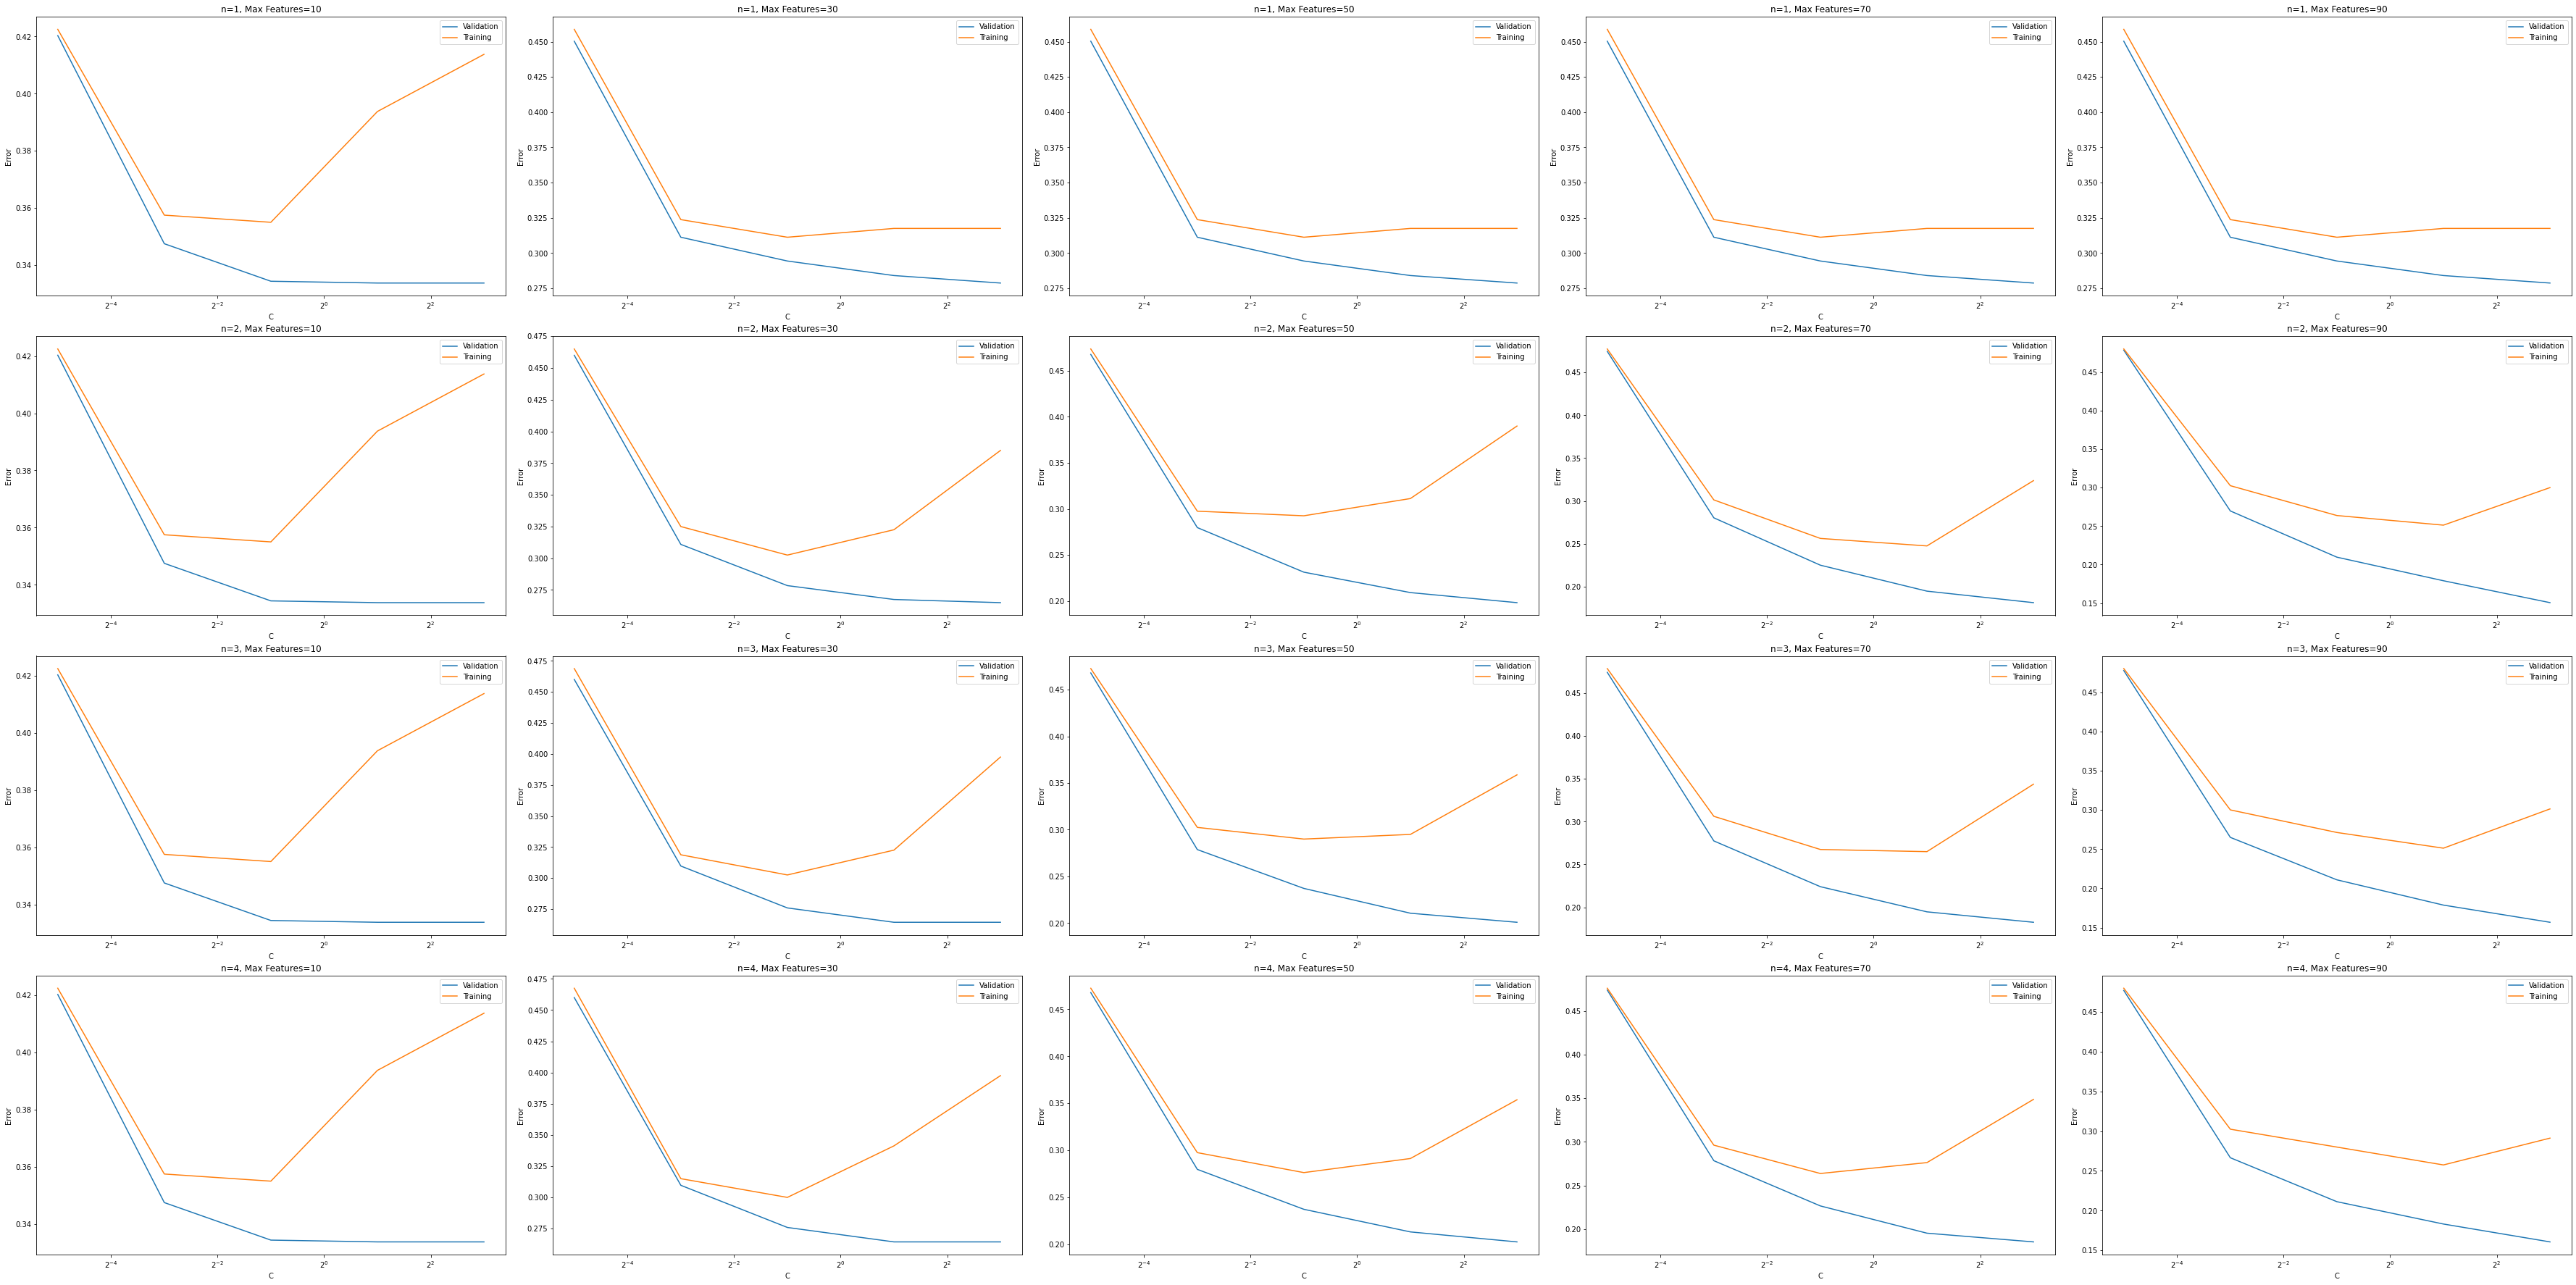

In [ ]:
graficaserrores(X_train,Y_train,"cosine")

**Gráficas con el kernel de $\chi^2$**

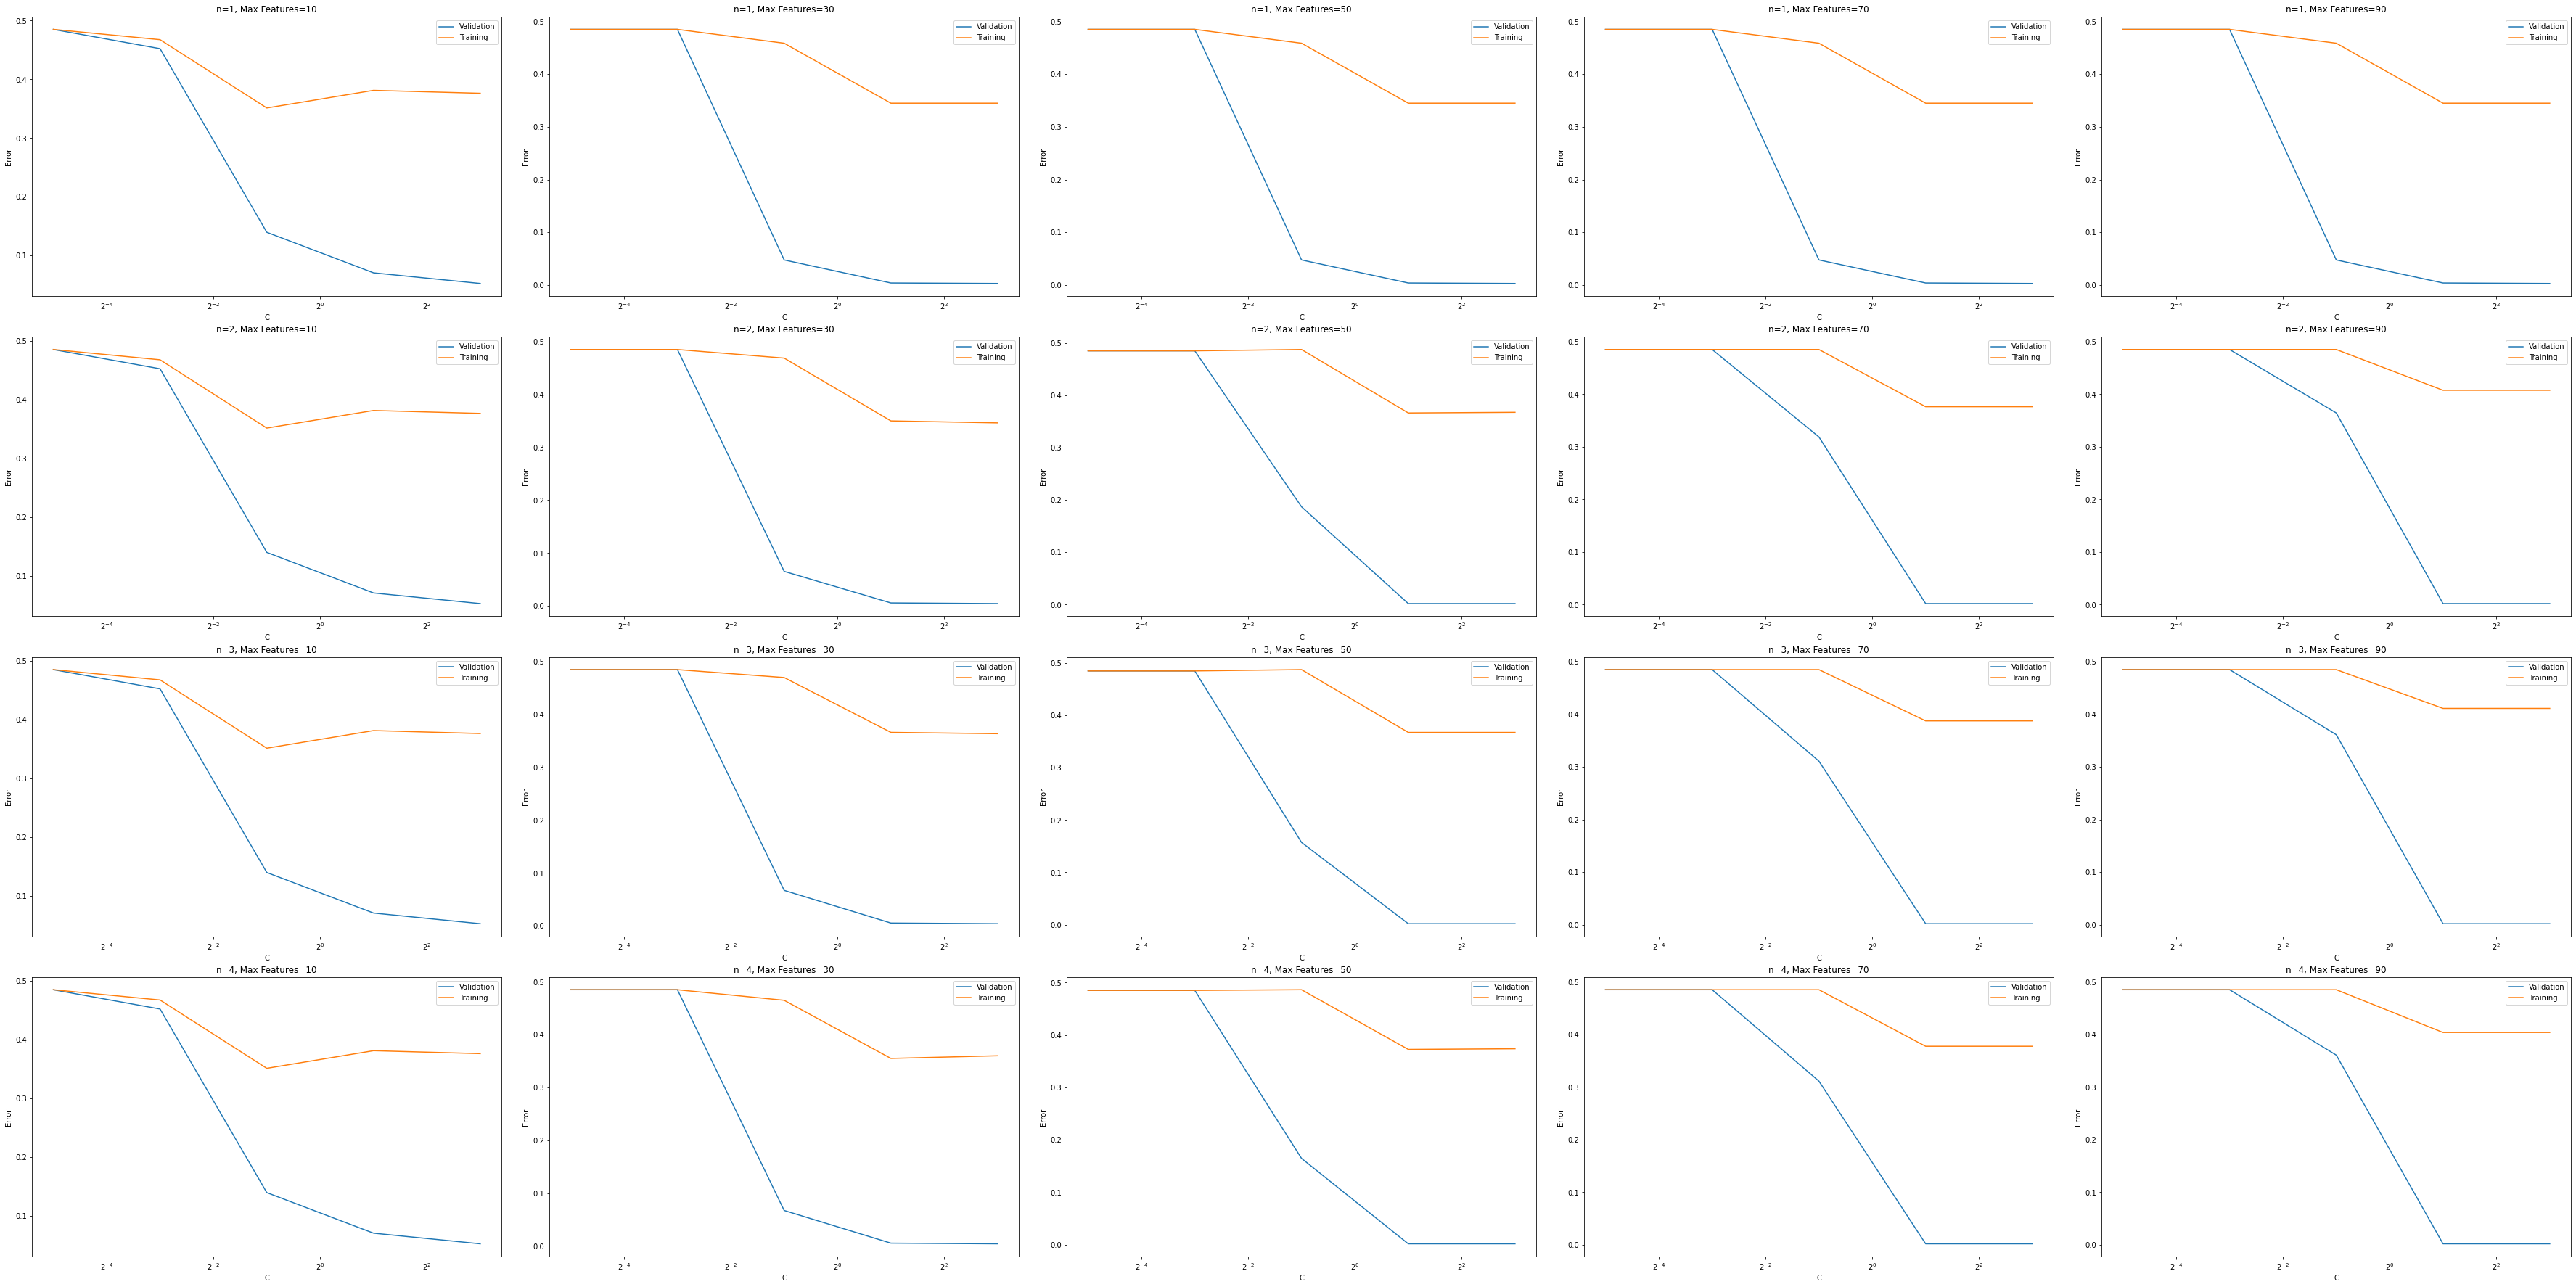

In [ ]:
graficaserrores(X_train,Y_train,"chi")

**Gráficas con el kernel de intersección de histogramas**

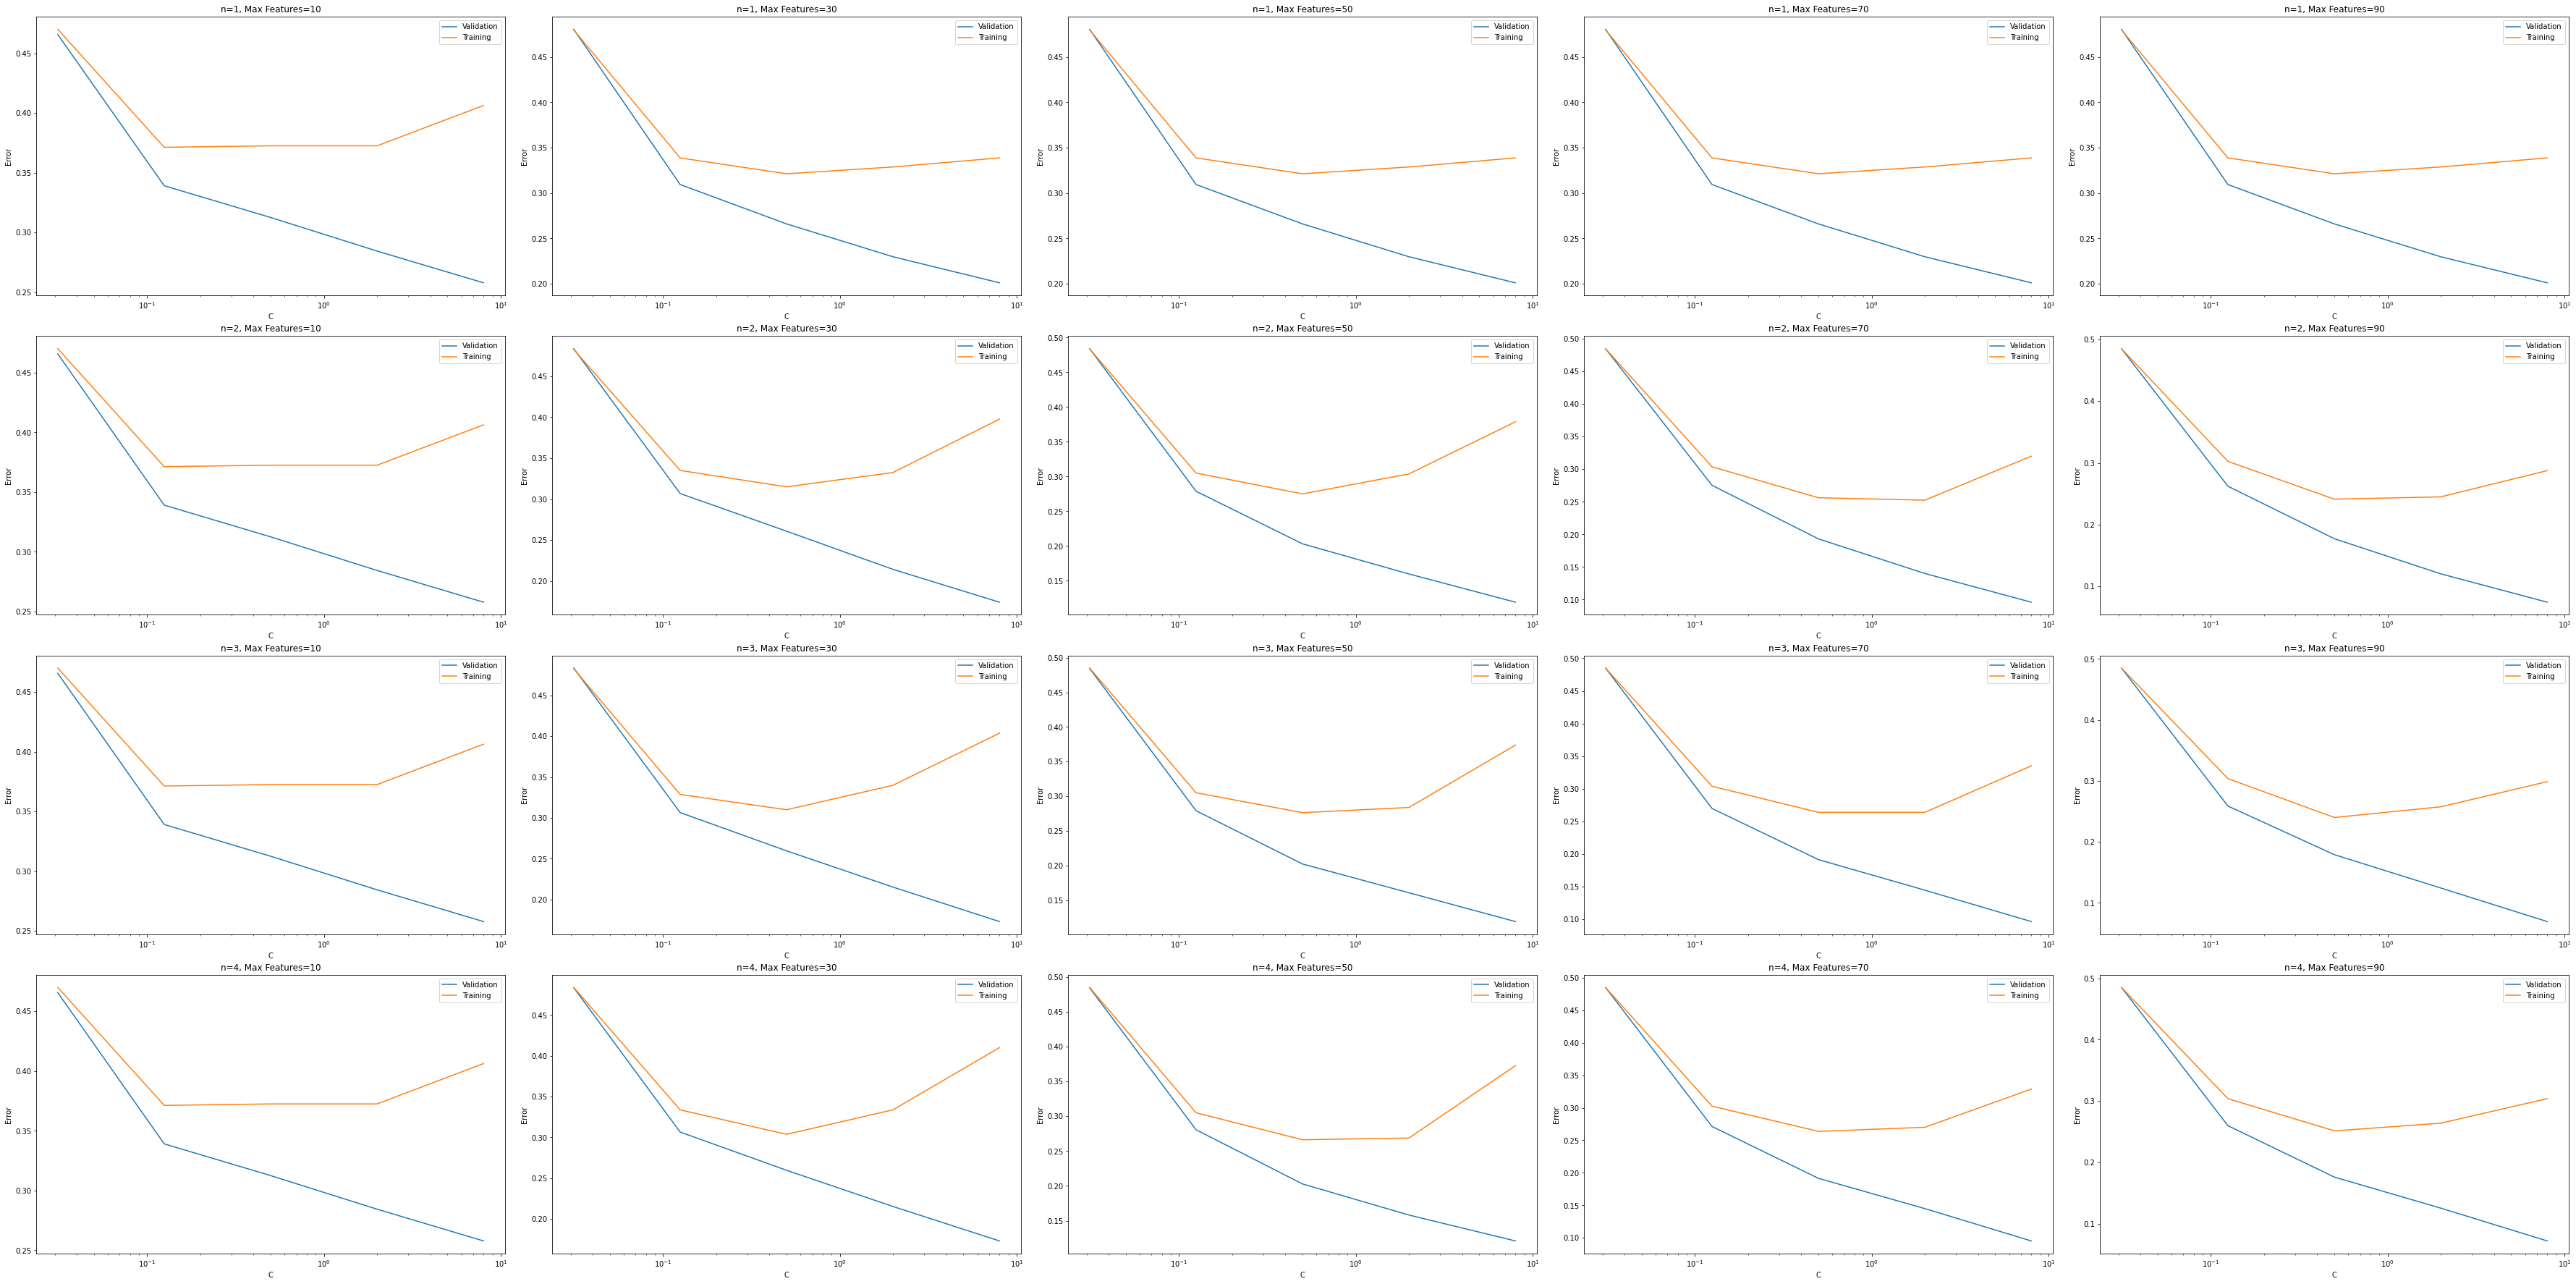

In [ ]:
graficaserrores(X_train,Y_train,"HIN")

**Gráficas con el kernel de caracteres**

In [ ]:
graficaserrores(X_train,Y_train,"SK")

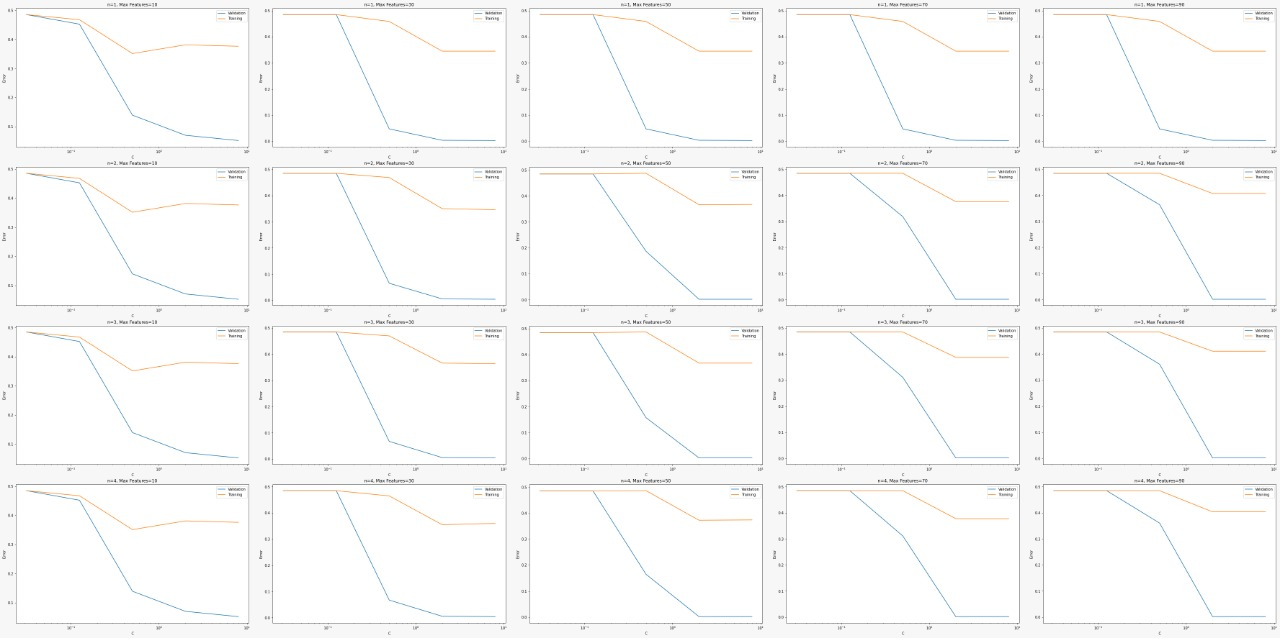

##D.

In [88]:
def Report(X_train,Y_train,X_test,Y_test,MP):
    #MP=np.array([[1,2,3],[4,6,6],[4,1,4],[12,3,5]])
    KS=["cosine","chi","HIN","SK"]
    DF=[]
    i=0
    accuracy_test=[]

    #Dataframe de datos mal clasificados
    Mal_data = pd.DataFrame(columns=KS,
                  index=range(15))

    #Necesario para que tomen valores binarios
    Y_train=Y_train>0.5
    Y_test=Y_test>0.5
    
    for K in KS:
      #Escogiendo los mejores hiperparámetros para cada kernel
      ngrams,max_features,C=MP[i]
      ngrams,max_features=int(ngrams),int(max_features)
      #Hallando el kernel con estos hiperparametros
      mgram=kernels(X=X_train,Y=None, ngrams=ngrams,max_features=max_features,kernel=K)

      #Hallando la matriz entre los datos de entrenamiento y los datos test, debe ir siempre primero el test
      KX_X1=kernels(X=X_test,Y=X_train, ngrams=ngrams,max_features=max_features,kernel=K)

      #Hallando el clasificador con los datos train
      clf=svm.SVC(C,kernel="precomputed")
      clf.fit(mgram,Y_train)

      #predicciont=clf.predict(mgram)#vector entrenamiento
      
      #Predicción del conjunto test, saca un vector de 1 y 0
      prediccionv=clf.predict(KX_X1)#vector validacion
      
      #Buscando los mal clasificados
      posiciones=np.where(Y_test!=prediccionv)
      posiciones=posiciones[0][0:50]
      for j in range(15):
        Mal_data.iloc[j][i]=X[posiciones[j]]

      accuracy_test.append(accuracy_score(Y_test,prediccionv))
      
      DF.append([K,MP[i],1-accuracy_score(Y_test,prediccionv)])
      i+=1
    
    DF=pd.DataFrame(DF)
    DF.columns=['Kernel','Parámetros[Ngram,Features,C]','Error en Test']  
    return DF ,Mal_data
    
#Los mejores parámetros escogidos de las gráficas y los datos mal clasificados
MatParametros=np.array([[3,40,0.5],[3,10,0.5],[3,90,0.5],[3,10,1]])
Report, Mal_clasf=Report(X_train,Y_train,X_test,Y_test,MatParametros)

### Repote de resultados

In [89]:
Report

,Kernel,"Parámetros[Ngram,Features,C]",Error en Test
0,cosine,"[3.0, 40.0, 0.5]",0.240
1,chi,"[3.0, 10.0, 0.5]",0.345
2,HIN,"[3.0, 90.0, 0.5]",0.245
3,SK,"[3.0, 10.0, 1.0]",0.155


###Datos mal clasificados


In [90]:
Mal_clasf

,cosine,chi,HIN,SK
0,interface,interface,military,husband
1,podrán,husband,whose,military
2,multiple,mechanism,scale,whose
3,scale,éstos,alianza,alianza
4,dirigentes,once,dirigentes,group
5,group,launch,realidad,realidad
6,pensó,multiple,pensó,william
7,llamada,forum,llamada,pensó
8,operación,fact,mayoría,llamada
9,raise,whose,operación,north


### Discusión

Concluimos que estos ejemplos mal clasificados ocurren porque están presentes- al quitar signos de acentuación en ambos idiomas o en gran parte de sus n-gramas estan presentes en ambos idiomas ej: militar-military, fact-factura, Escale-Scale, Once(11)-Once(Una Vez)

#Second Point


###A.

In [91]:
X=TotalData[0:5000,0]
Y=TotalData[0:5000,1]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [92]:
def n_grams(X,Y=None, n=1, max_features=10):
  if Y is None:
    Y=X.copy() 
  vectorizer = CountVectorizer(strip_accents='ascii',analyzer='char',max_features=max_features,ngram_range=(1,n))
  X = vectorizer.fit_transform(X).toarray()
  Y = vectorizer.transform(Y).toarray()

  #Obtiene los n_gramas del vector de palabras 
  N=vectorizer.get_feature_names()
   
  #Covirtiendo en matriz los n-gramas de Y
  DF=pd.DataFrame(Y)
  DF.columns=N
  return DF

MATRIZH=n_grams(X,n=4,max_features=1000)
MATRIZH

,a,ab,aba,abe,abi,abl,able,abo,ac,ace,aci,acio,act,acti,ad,ada,ade,ades,adi,ado,af,ag,age,ai,ail,ain,aj,al,ala,ale,ales,ali,all,ally,alm,alt,am,ama,amb,ame,...,urs,us,use,ust,ut,uti,v,va,val,ve,vel,ven,ver,vers,ves,vi,vic,vid,vie,vis,visi,vo,vol,w,wa,we,wh,wi,wo,wor,x,xi,xp,xt,y,ye,yo,z,za,zo
0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3616,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3617,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##B.
Identificando los vectores de soporte

In [93]:
def vectores_de_soporte(X,Y,C=1,n=1,max_features=10,kerne="cosine"):
  #Hallando el kernel con los datos de entrenamineto
  mgram=kernels(X=X,Y=None,ngrams=n,max_features=90,kernel=kerne)
  #Se entrena el modelo
  clf=svm.SVC(C=C,kernel="precomputed")
  Y=Y>0.5
  clf.fit(mgram,Y)
  Suport_vector=X[clf.support_]
  coeficientes_duales=clf.dual_coef_[0]
  return clf,Suport_vector,coeficientes_duales

In [94]:
clf,SVM, Coef_dual=vectores_de_soporte(X=X_train,Y=Y_train,C=0.5, n=3,max_features=90,kerne="HIN")

In [100]:
SVM
Tabla=pd.DataFrame( SVM.reshape((len(SVM),1)),columns=["Vectores de soporte"])
Tabla

,Vectores de soporte
0,película
1,ganar
2,requiere
3,mirar
4,mediante
...,...
1765,damage
1766,robert
1767,code
1768,enter


##C.
Vectores de soporte

In [ ]:
#Los vectores de soporte máximo se toman teniendo en cuenta las plabras que generan el máximo de los coeficientes duales
Max_SVM=X_train[np.where(Coef_dual==max(abs(Coef_dual)))]

Tabla_max=pd.DataFrame(Max_SVM.reshape((len(Max_SVM),1)), columns=["Vectores de soporte máximo"])
Tabla_max

##D

In [ ]:
puntajesm=[]
puntajesv=[]
Muestras=[]
#tomado muestras aleaotrias de los datos
for i in range(50):
  indices=np.random.choice(range(0,len(X)),size=250)
  Xmuestra=X[indices]
  Ymuestra=Y[indices]
  Ymuestra=Ymuestra>0.5
  Muestras.append([Xmuestra,Ymuestra])

  ######Obteniendo la matriz de vectores de soporte contra muestra
  KernelVS_M=kernelHIN(X=SVM,Y=Xmuestra, n=3,max_features=90)
  ##Modelo manual 
  ClFmuestra=Coef_dual@KernelVS_M+clf.intercept_[0]

  ##############################USANDO el modelo previamente ajustado
  KX_X1=kernels(X=Xmuestra,Y=X_train, ngrams=3,max_features=90,kernel="HIN")
  #Modelo de la paquetería 
  prediccionmuestra=clf.predict(KX_X1)

  ClFmuestra=ClFmuestra>0

  #La presición está dada por accuracy entre los label de muestra y los label obtenidos de modelo manual
  puntajeVSP=accuracy_score(Ymuestra,ClFmuestra)
  #La presición está dada por accuracy entre los label de muestra y los label obtenidos de modelo computado
  puntajemodel=accuracy_score(Ymuestra,prediccionmuestra)
  puntajesm.append(puntajemodel)
  puntajesv.append(puntajeVSP)
  #print(ClFmuestra,"\n",prediccionmuestra,"\n",Ymuestra>0.5)
  print("Puntaje Modelo Ajustado=", puntajemodel,"\t","Puntaje SVP=",puntajeVSP)
  print("___________________")
##############Esto tarda mas o menos 40 minutos de ejecución
print("EL puntaje promedio luego de 50 muestras aleatorias es:,","\n", f"Accuracy promedio Modelo{np.mean(puntajesm)}","\t",f"Accuracy promedio  SVP={np.mean(puntajesv)}")



## e. 

In [107]:
X_new=TotalData[0:2000,0]
Y_new=TotalData[0:2000,1]

#print("\x1b[;34m"+"Texto en negrita de color azul")
#print("\x1b[1;31m"+"Texto en negrita de color rojo")

vectorizer = CountVectorizer(strip_accents='ascii',analyzer='char',max_features=100,ngram_range=(2,4))
X = vectorizer.fit_transform(X_new).toarray()
#Hallar los N-gramas
N_gramas=vectorizer.get_feature_names()

#Entrenando el modelo, se debe hacer con todo los datos
Gram_modelo=kernels(X=X_new,ngrams=3,max_features=90,kernel="HIN")
clf_ngram=svm.SVC(C=0.5,kernel="precomputed")
Y_new=Y_new>0.5
#Se debe ajustar el modelo con la matriz obtenida del modelo del kernel
clf_ngram.fit(Gram_modelo,Y_new)

#Matriz para predecir
Gram_caracteres=kernels(X=N_gramas,Y=X_new , ngrams=3,max_features=90,kernel="HIN")
#Modelo de la paquetería 
prediccion_ngramas=clf_ngram.predict(Gram_caracteres)

Distinguiendo palabras ngramas del inglés y del español

In [ ]:

i=0
for ngram in N_gramas:
  if prediccion_ngramas[i]==True:
    print("\033[1;32m"+ngram,"  Inglés  ")
    
  else:
    print("\033[1;35m"+ngram, "  Español  ")
  i+=1

#Third Point

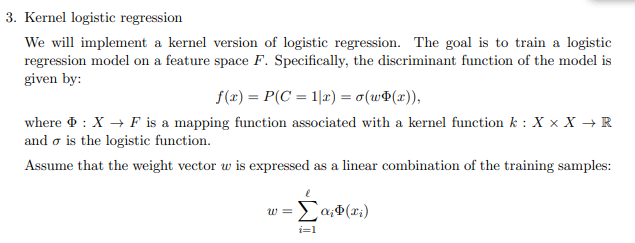



* **a.)** Write a expression of the discriminant function expressed in terms of the kernel and the coefficients $α_i$.

being  $~~~w=\sum_{i=1}^l{\alpha_i \Phi(x_i)}$, then 
$$w\cdot \Phi(x)=\sum_{i=1}^l{\alpha_i \Phi(x_i)}\cdot\Phi(x)$$


$$w\cdot \Phi(x)=\sum_{i=1}^l{\alpha_i K(x_i,x)}$$

where $K(x_i,x)=<\Phi(x_i),\Phi(x)>$

thus the classifier function is defined as:
$$f(x)=\dfrac{1}{1+e^{-\sum_{i=1}^l{\alpha_i K(x_i,x)}}}$$

**b.)**Formulate the problem of learning the parameters of the model as an optimization problem that looks for the parameters $α_i$ that minimize a cross entropy loss function.

The cross entropy loss function is defined as:

$$\begin{align*}
E(\alpha |X)&=-\sum_{i}{y_i \log(f(x_i))+(1-y_i)\log(1-f(x_i))}\\
\dfrac{\partial E}{\partial \alpha_j}&=-\sum_{i}{\frac{y_i}{f(x_i)}f_{\alpha_j}(x_i) -\frac{1-y_i}{1-f(x_i)}f_{\alpha_j}(x_i)}\\
\dfrac{\partial E}{\partial \alpha_j}&=-\sum_{i}{\left ( \frac{y_i}{f(x_i)} -\frac{1-y_i}{1-f(x_i)}\right )f_{\alpha_j}(x_i)}\\
\dfrac{\partial E}{\partial \alpha_j}&=-\sum_{i}{\left ( \frac{y_i}{f(x_i)} -\frac{1-y_i}{1-f(x_i)}\right )f(x_i)(1-f(x_i))K(x_j,x_i)}\\
\dfrac{\partial E}{\partial \alpha_j}&=-\sum_{i}{\left (\frac{y_i -y_if(x_i)-f(x_i)+y_i f(x_i)}{f(x_i)(1-f(x_i))}\right ) f(x_i)(1-f(x_i))K(x_j,x_i)}\\
\dfrac{\partial E}{\partial \alpha_j}&=-\sum_{i}{(y_i-f(x_i))K(x_j,x_i)}\\
\end{align*}$$



##Algoritmo

###Codigo para gráficas.


In [ ]:
from sklearn.datasets import make_circles, make_moons
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import warnings
import math as mt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

warnings.filterwarnings('ignore')

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y != this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    #plt.title("")

def plot_decision_region_modificada(X,X_train,alpha,kernel):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
          vector=np.array([XX[i,j],YY[i,j]])
          ZZ[i, j] =func_discriminadora1(X_train,alpha,vector,kernel)[1]
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= -1, vmax=2)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")







####Fórmulas de Kernels comunes
 **Kernel polinomial**
La función $k$ está definida como:
$$
k(x,y) = (\gamma \langle x, y\rangle + r)^d
$$
 **Kernel lineal**
$$
k(x,y) = \langle x, y\rangle = xy'
$$

**Kernel Gaussiano**
$$
K(x, x') = \exp\left(-\frac{\|x-x'\|^2}{2\sigma^2}\right)
$$
la cual se puede simplificar como
$$
K(x, x') = \exp(-\gamma \|x-x'\|^2)
$$
$$
\gamma \ = \frac{1}{2\sigma^2}
$$

In [ ]:
def kernelPoly(x,y,gamma=2,r=-3,d=3):
  '''
  Debe ser una función a valor real.
  x: vector shape (1,2)
  y: vector shape (1,2)
  defina aqui su función
  '''
  return (gamma*np.dot(x,y)+r)**d

def kernelLineal(x,y):
  '''
  Debe ser una función a valor real.
  x: vector shape (1,2)
  y: vector shape (1,2)
  defina aqui su función
  '''
  return np.dot(x,y)

def kernelGaussian(x,y,gamma=1):
  return mt.exp(-gamma*np.linalg.norm(x-y)**2)


##recuerde una función a valor real.


### Indique su kernel

In [ ]:
def SuKernel(x,y):
  '''
  Debe ser una función a valor real.
  x: vector shape (1,2)
  y: vector shape (1,2)
  defina aqui su función
  '''
  return np.dot(x,y)

###Código para el método de gradiente descendiente

In [ ]:
def matrizgram(xtrain,kernel):
  gram=np.zeros(shape=(len(xtrain),len(xtrain))) 
  for i in range(len(xtrain)):
    for j in range(len(xtrain)):
      gram[i,j]=kernel(xtrain[i],xtrain[j])
  return gram

def func_discriminadora1(Xtrain,alpha,x,kernel):
    ''' 
     evaule en vector x
     alpha : vector with shape (L,)
     Xtrain: vector with shape (L,2)
     x: sample with shape (1,2)
     returns: Resultado and clase
    '''
    Kvector=[]
    for i in Xtrain:
      Kvector.append(kernel(i,x))
    
    Kvector=np.array(Kvector)
    #Kvector=kernel(Xtrain,x)##Cada elemenoto es K(x_i,x)
    real=alpha@Kvector
    resultado=1 / (1 +  np.exp(-real))
    clase=round(resultado)  

    return  resultado,clase

def func_discriminadora2(Xtrain,alpha,Xconjunto,kernel):
  '''Funcion discriminadora para un conjunto de puntos de R2
  Xtrain tamaño (L,2)
  alpha shape (L,)
  Xconjunto shape (M,2)
  '''
  Vresultado=[]
  Vclase=[]
  for i in Xconjunto:
    Vresultado.append(func_discriminadora1(Xtrain,alpha,i,kernel)[0])
    Vclase.append(func_discriminadora1(Xtrain,alpha,i,kernel)[1])
  
  return Vresultado, Vclase

 #####escontrando los alpha optimos con el método de  gradiente descendente

def gradient(xtrain, ytrain,alpha,kernel):
   gradiente=-matrizgram(xtrain,kernel)@(ytrain-func_discriminadora2(xtrain,alpha,xtrain,kernel)[0])
   return gradiente

def gradient_descent(xtrain,ytrain, learn_rate,iter,  tolerance,kernel):
    matrizalpha=np.zeros(shape=(iter+1,len(xtrain))) 
    scores=[]
    alpha=np.random.uniform(-0.001, 0.001,len(xtrain))
    pasos=0
    while True:
      matrizalpha[pasos]=alpha
      clfalpha=func_discriminadora2(xtrain,alpha,xtrain,kernel)[1]
      auc=roc_auc_score(ytrain,clfalpha)
      scores.append(auc)
      diff = -learn_rate*gradient(xtrain,ytrain,alpha,kernel)
      if np.all(np.linalg.norm(diff)<= tolerance):
        break
      if np.all(ytrain-clfalpha==0):
        break
      if pasos==iter:
        max_value=max(scores)
        indicemax=scores.index(max_value)
        alpha=matrizalpha[indicemax]
        break
      alpha += diff
      pasos+=1

    return alpha



##Comparativa del Método-Clasificaciones dadas

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

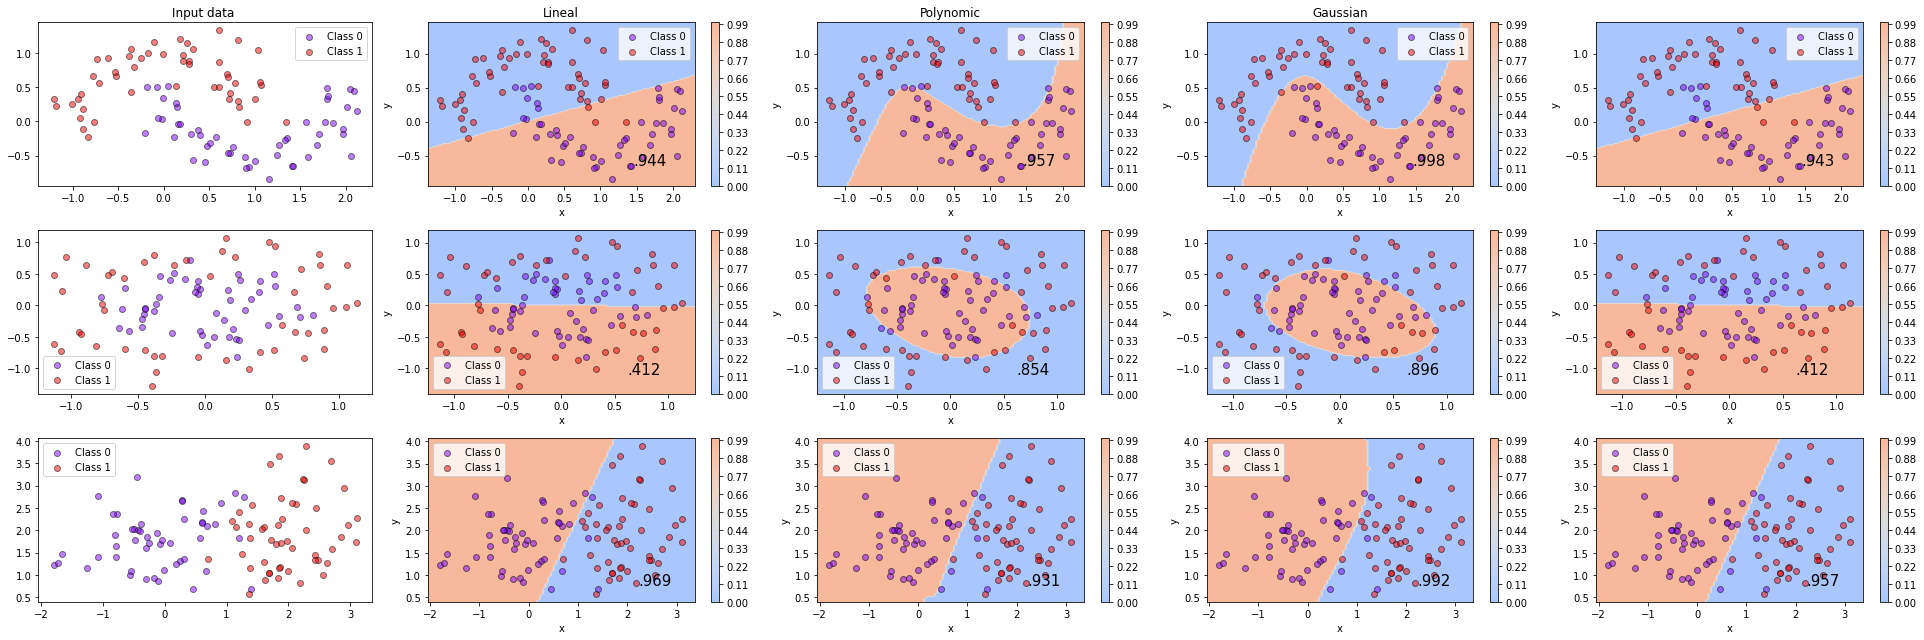

In [ ]:
h = .02  # step size in the mesh
###Obteniendo los datos
X, y = make_classification(100,n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
#names = ["Lineal", "Poliniomio grado 2", "Polinomio Grado 3", "Gaussian Process"]
names = ["Linear", "Polynomic","Gaussian","SuKernel"
         #"Random Forest", "Neural Net", "AdaBoost",
         #"Naive Bayes", "QDA"
         ]
classifiers = [1,2,3,4
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
    ]

datasets = [make_moons(100,noise=0.2, random_state=0),
            make_circles(100,noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]


figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets

for ds_cont,ds in enumerate(datasets):
    
    # preprocess dataset, split into training and test part
    X, y = ds
    #X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.7, random_state=42)
####Esto sonlo sirve para poner los puntos mas centrados
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers)+1, i)
    if i == 1:
        ax.set_title("Input data ")
    plot_data(X,y)
    i +=1
    # iterate over classifiers
    ########################primera fila 
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    alpha=gradient_descent(X_train,y_train,learn_rate=0.8,iter=250,tolerance=1e-3,kernel=kernelLineal)
    clfalpha,_=func_discriminadora2(X_train,alpha,X_test,kernel=kernelLineal)
    score=roc_auc_score(y_test,clfalpha)
    plot_decision_region_modificada(X,X_train,alpha,kernel=kernelLineal)
    plot_data(X,y)
    if i==2:
        ax.set_title("Lineal")
    ax.text(xx.max() - .7, yy.min() + .7, ('%.3f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i +=1
    ###siguiente elemento
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    alpha=gradient_descent(X_train,y_train,learn_rate=0.8,iter=250,tolerance=1e-3,kernel=kernelPoly)
    clfalpha,_=func_discriminadora2(X_train,alpha,X_test,kernel=kernelPoly)
    score=roc_auc_score(y_test,clfalpha)
    plot_decision_region_modificada(X,X_train,alpha,kernel=kernelPoly)
    plot_data(X,y)
    if i==3:
      ax.set_title("Polynomic")
    
    ax.text(xx.max() - .7, yy.min() + .7, ('%.3f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i +=1
    ###siguiente elemento
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    alpha=gradient_descent(X_train,y_train,learn_rate=0.8,iter=250,tolerance=1e-3,kernel=kernelGaussian)
    clfalpha,_=func_discriminadora2(X_train,alpha,X_test,kernel=kernelGaussian)
    score=roc_auc_score(y_test,clfalpha)
    plot_decision_region_modificada(X,X_train,alpha,kernel=kernelGaussian)
    plot_data(X,y)
    if i==4:
        ax.set_title("Gaussian")
    ax.text(xx.max() - .7, yy.min() + .7, ('%.3f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i +=1
    ###siguiente elemento
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    alpha=gradient_descent(X_train,y_train,learn_rate=0.8,iter=250,tolerance=1e-3,kernel=SuKernel)
    clfalpha,_=func_discriminadora2(X_train,alpha,X_test,kernel=SuKernel)
    score=roc_auc_score(y_test,clfalpha)
    plot_decision_region_modificada(X,X_train,alpha,kernel=SuKernel)
    plot_data(X,y)
    if i==4:
        ax.set_title("Gaussian")
    ax.text(xx.max() - .7, yy.min() + .7, ('%.3f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i +=1
      

plt.tight_layout()
plt.show()